# ASEを使ってQE用の構造モデル(金属スラブ、分子吸着モデル）を作成する

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
if importlib.util.find_spec("ase") is None:
    !pip install git+https://github.com/minoru-otani/ase.git@qe_rism

In [3]:
import copy
import matplotlib.pyplot as plt
from ase import Atoms
from ase.io import read, write
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.constraints import FixAtoms
from ase.io.cube import read_cube_data
from ase.build import fcc111, graphene, add_adsorbate, molecule
from ase.geometry import wrap_positions

## Slabモデルを作成する

ASEにはあらかじめ典型的な表面構造を作る関数が用意されている。用意されている構造をリストする。詳しくは[ase.build.surface](https://wiki.fysik.dtu.dk/ase/_modules/ase/build/surface.html)を参照。

||||||||
|---|---|---|---|---|---|---| 
|Surface|fcc(100)|fcc(110)|fcc(111)|bcc(100)|bcc(110)|bcc(111)|
|Adsorption site|ontop, bridge<br>hollow|ontop, longbridge<br>shortbridge, hollow|ontop, bridge<br>fcc, hcp|ontop, bridge<br>hollow|ontop, longbridge<br>shortbridge, hollow|ontop|
|Surface|hcp(0001)|hcp(10$\bar{1}$0)|diamond(111)|diamond(100)|mx2|graphene|
|Adsorption site|ontop, bridge<br>fcc, hcp|ontop|ontop|ontop|||

### 吸着サイトの情報を見る

吸着サイトの指定の仕方は二通りある：```ontop```などのキーワードを与える方法と、$(x,y)$を直接与える方法である。各表面構造関数が持っている吸着サイトは以下のように調べることができる。例として```fcc(111)```表面に用意されている吸着サイトを表示してみる。

In [4]:
slab = fcc111('Al', size=(1,1,5), vacuum=10.0)
slab.info.get('adsorbate_info', {})

{'cell': array([[2.86378246, 0.        ],
        [1.43189123, 2.48010836]]),
 'sites': {'ontop': (0, 0),
  'bridge': (0.5, 0),
  'fcc': (0.3333333333333333, 0.3333333333333333),
  'hcp': (0.6666666666666666, 0.6666666666666666)}}

このように、```ontop, bridge, fcc```および```hcp```サイトがあることが分かる。もし、あらかじめ用意されている吸着サイトがない場合は何も表示されない。

In [5]:
slab = graphene(formula='C2', size=(1,1,1), vacuum=10.0)
slab.info.get('adsorbate_info', {})

{}

このような場合は、直接$xy$座標を指定して吸着サイトを指定する必要がある。（詳しくは下で説明します。）

### fcc(111)表面を作る

fcc111関数を用いて表面を作成する。```size```で表面の周期とスラブの厚みを設定できる。左右の真空の厚みはそれぞれ```lvac```と```rvac```で指定できる。

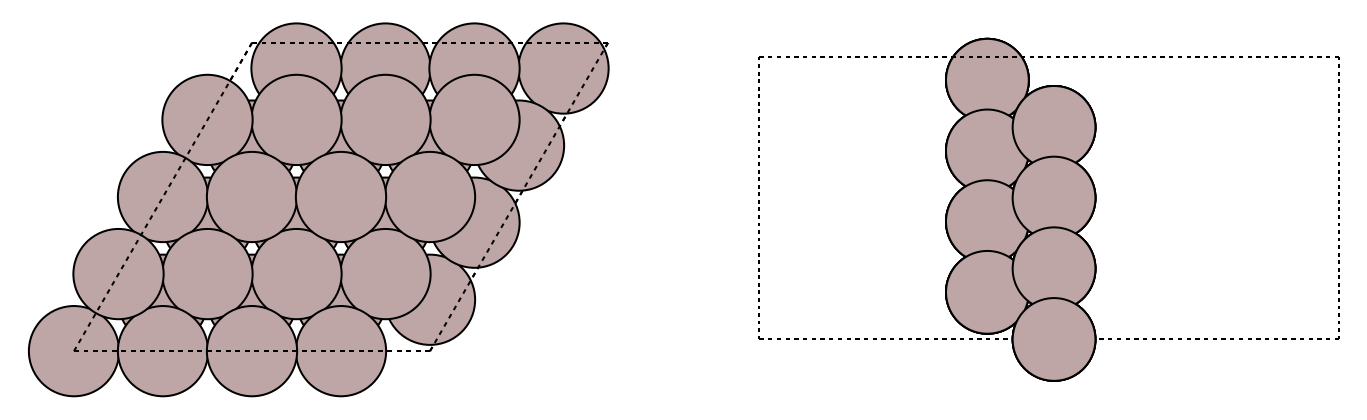

In [6]:
lvac = 8.0 # 左側の真空の厚み
rvac = 10.0 # 右側の真空の厚み
vac = (lvac + rvac)/2.0 # 表面構造関数には真空の左右の真空の厚みの半分を渡す
slab = fcc111('Al', size=(4,4,2), vacuum=vac)
slab.wrap() # 普通に作ると、ユニットセルをはみ出す原子があるので、ユニットセル内にwrapする。
slab.translate((0.0,0.0,(lvac-rvac)/2.0)) # lvac, rvacを反映した位置にずらす
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].set_axis_off()
ax[1].set_axis_off()
plot_atoms(slab, ax[0], radii=1.2, rotation=('0x,0y,0z'))
plot_atoms(slab, ax[1], radii=1.2, rotation=('90x,90y,90z'))
#view(slab, viewer='ngl')
plt.show()

スラブが意図した通り作成できているかを```slab```の中身を見て確認する。

In [7]:
aobj = slab
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = ( 11.45513,   0.00000,   0.00000)
            b = (  5.72756,   9.92043,   0.00000)
            c = (  0.00000,   0.00000,  20.33827)
 Number of atoms:    32
 Species, Positions:
  'Al' ( 11.45513,   1.65341,   8.00000)
  'Al' (  2.86378,   1.65341,   8.00000)
  'Al' (  5.72756,   1.65341,   8.00000)
  'Al' (  8.59135,   1.65341,   8.00000)
  'Al' ( 12.88702,   4.13351,   8.00000)
  'Al' (  4.29567,   4.13351,   8.00000)
  'Al' (  7.15946,   4.13351,   8.00000)
  'Al' ( 10.02324,   4.13351,   8.00000)
  'Al' ( 14.31891,   6.61362,   8.00000)
  'Al' (  5.72756,   6.61362,   8.00000)
  'Al' (  8.59135,   6.61362,   8.00000)
  'Al' ( 11.45513,   6.61362,   8.00000)
  'Al' ( 15.75080,   9.09373,   8.00000)
  'Al' (  7.15946,   9.09373,   8.00000)
  'Al' ( 10.02324,   9.09373,   8.00000)
  'Al' ( 12.88702,   9.09373,   8.00000)
  'Al' (  0.00000,   0.00000,  10.33827)
  'Al' (  2.86378,   0.00000,  10.33827)
  'Al' (  5.72756,   0.00000,  10.33827)
  'Al' (  8.59135,   0.000

### 分子吸着を考えるために分子を用意する

二酸化炭素を作成してみる。

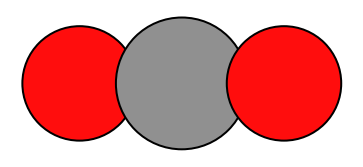

In [8]:
atoms_co2 = molecule('CO2')
fig, ax = plt.subplots(1,1, figsize=(3,1.5))
ax.set_axis_off()
plot_atoms(atoms_co2, ax, radii=1.0, rotation=('0x,90y,0z'))
plt.show()
#view(atoms, viewer='ngl')

座標を確認する

In [9]:
aobj = atoms_co2
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Number of atoms:     3
 Species, Positions:
  'C ' (  0.00000,   0.00000,   0.00000)
  'O ' (  0.00000,   0.00000,   1.17866)
  'O ' (  0.00000,   0.00000,  -1.17866)


水分子を作成してみる。

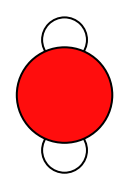

In [10]:
atoms_h2o = molecule('H2O')
fig, ax = plt.subplots(1,1, figsize=(3,1.5))
ax.set_axis_off()
plot_atoms(atoms_h2o, ax, radii=1.0, rotation=('0x,0y,0z'))
plt.show()

座標を確認する

In [11]:
aobj = atoms_h2o
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Number of atoms:     3
 Species, Positions:
  'O ' (  0.00000,   0.00000,   0.11926)
  'H ' (  0.00000,   0.76324,  -0.47705)
  'H ' (  0.00000,  -0.76324,  -0.47705)


### 分子を表面に置く

上で作った```slab```に水分子と二酸化炭素を置いてみる。まずは```fcc111```が持っている```ontop```サイトに水分子を酸素が下向きになるように置いてみる。分子を置くには```add_adsorbate```関数を使う。引数の意味は以下の通り(より詳しくは[ase.build.surface](https://wiki.fysik.dtu.dk/ase/_modules/ase/build/surface.html)を参照):<BR>
```height```: 吸着分子の高さを指定<BR>
```position```: 吸着位置を指定。```ontop```などのキーワードでも、直接$xy$座標を与えても良い<BR>
```offset```: 吸着分子をずらす。表面の単位格子に対してオフセットさせる。整数値を与えると```position```で与えたサイト上に置かれるが、1/2などで別の吸着サイトへオフセットさせることも可能。<BR>
```mol_index```: 吸着分子の```mol_index```番目の原子が吸着サイトの真上に来るように微調整する。

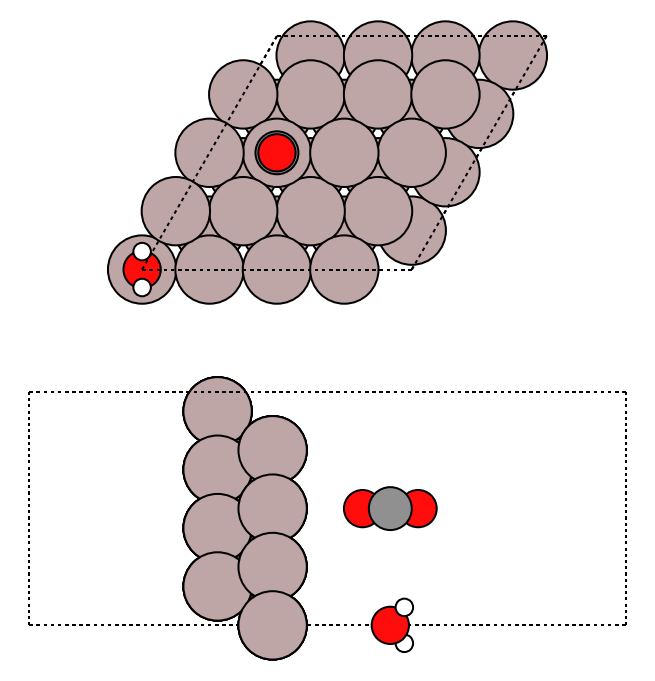

In [12]:
# スラブを作成
lvac = 8.0 # 左側の真空の厚み
rvac = 15.0 # 右側の真空の厚み
vac = (lvac + rvac)/2.0 # 表面構造関数には真空の左右の真空の厚みの半分を渡す
slab = fcc111('Al', size=(4,4,2), vacuum=vac)
slab.wrap() # 普通に作ると、ユニットセルをはみ出す原子があるので、ユニットセル内にwrapする。
slab.translate((0.0,0.0,(lvac-rvac)/2.0)) # lvac, rvacを反映した位置にずらす
atoms_h2o.rotate(180, 'x', center=(0,0,0)) # 酸素が下になるように回転させる。
# ```ontop```サイトの上に水分子を置く
add_adsorbate(slab,atoms_h2o,height=5.0, position='ontop', offset=(0, 0), mol_index=0)
add_adsorbate(slab,atoms_co2,height=5.0, position='ontop', offset=(1, 2), mol_index=0)
fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].set_axis_off()
ax[1].set_axis_off()
plot_atoms(slab, ax[0], radii=1.2, rotation=('0x,0y,0z'))
plot_atoms(slab, ax[1], radii=1.2, rotation=('90x,90y,90z'))
plt.show()

### ESM/ESM-RISM計算用にスラブをずらす

上のスラブの例ではユニットセルが、$z=0$から$z=L_z$だと思って原子を配置している。ここで、$L_z$は$z$軸方向のユニットセルの大きさを表す。ESMやESM-RISM計算ではユニットセルの位置が$-L_z/2$から$L_z/2$として原子を配置する必要がある。そこで、ESM/ESM-RISM計算用のインプットを作るために、原子位置を$L_z/2$だけ左にずらす。

In [13]:
slab_ESM = copy.deepcopy(slab)
slab_ESM.translate((0.0,0.0,-slab.cell[2,2]/2.0)) # shift atoms to fit ESM/ESM-RISM model
#fig, ax = plt.subplots(2,1, figsize=(12, 6))
#ax[0].set_axis_off()
#ax[1].set_axis_off()
#plot_atoms(slab_ESM, ax[0], radii=1.0, rotation=('0x,0y,0z'))
#plot_atoms(slab_ESM, ax[1], radii=1.0, rotation=('90x,90y,90z'))
#plt.show()

原子座標などを確認する。ここで、確認することは、
- スラブの左端の原子の$z$座標が$-L_z/2+$ ```lvac```となっているか。
- スラブの右端の原子の$z$座標が$L_z/2-$ ```rvac```となっているか。
- 分子を吸着している場合は、吸着分子の右端の原子から$L_z/2$までに十分な真空領域が確保されているか。（最低でも8Aは必要）

In [14]:
aobj = slab_ESM
print(f' Unit cell: a = ({aobj.cell[0,0]:9.5f}, {aobj.cell[0,1]:9.5f}, {aobj.cell[0,2]:9.5f})')
print(f'            b = ({aobj.cell[1,0]:9.5f}, {aobj.cell[1,1]:9.5f}, {aobj.cell[1,2]:9.5f})')
print(f'            c = ({aobj.cell[2,0]:9.5f}, {aobj.cell[2,1]:9.5f}, {aobj.cell[2,2]:9.5f})')
print(f' Number of atoms: {len(aobj.positions):5d}')
print(f' Species, Positions:')
for i in range(len(aobj.positions)):
    print(f'  \'{aobj.symbols[i]:<2}\' ({aobj.positions[i,0]:9.5f}, {aobj.positions[i,1]:9.5f}, {aobj.positions[i,2]:9.5f})')

 Unit cell: a = ( 11.45513,   0.00000,   0.00000)
            b = (  5.72756,   9.92043,   0.00000)
            c = (  0.00000,   0.00000,  25.33827)
 Number of atoms:    38
 Species, Positions:
  'Al' ( 11.45513,   1.65341,  -4.66913)
  'Al' (  2.86378,   1.65341,  -4.66913)
  'Al' (  5.72756,   1.65341,  -4.66913)
  'Al' (  8.59135,   1.65341,  -4.66913)
  'Al' ( 12.88702,   4.13351,  -4.66913)
  'Al' (  4.29567,   4.13351,  -4.66913)
  'Al' (  7.15946,   4.13351,  -4.66913)
  'Al' ( 10.02324,   4.13351,  -4.66913)
  'Al' ( 14.31891,   6.61362,  -4.66913)
  'Al' (  5.72756,   6.61362,  -4.66913)
  'Al' (  8.59135,   6.61362,  -4.66913)
  'Al' ( 11.45513,   6.61362,  -4.66913)
  'Al' ( 15.75080,   9.09373,  -4.66913)
  'Al' (  7.15946,   9.09373,  -4.66913)
  'Al' ( 10.02324,   9.09373,  -4.66913)
  'Al' ( 12.88702,   9.09373,  -4.66913)
  'Al' (  0.00000,   0.00000,  -2.33087)
  'Al' (  2.86378,   0.00000,  -2.33087)
  'Al' (  5.72756,   0.00000,  -2.33087)
  'Al' (  8.59135,   0.000

# ESM-RISM用のインプットファイルを作成する。

In [15]:
pseudopotentials = {'Al':'Al.pbe-n-van.UPF'}
input_data = {
    'control': {
        'calculation': 'scf',
        'restart_mode': 'from_scratch',
        'prefix': 'Al100_bc1',
        'disk_io': 'low',
        'lfcp': True,
        'trism': True,
    },
    'system': {
        'ibrav': 0,
        'ecutwfc': 20,
        'ecutrho': 160,
        'occupations' : 'smearing',
        'smearing':'mp',
        'degauss' : 0.03,
        'assume_isolated': 'esm',
        'esm_bc': 'bc1'
    },
    'electrons': {
        'mixing_beta': 0.3,
    },
    'fcp': {
        'fcp_mu': -3.5
    }
}
 
solv_info={
    'density_unit' : 'mol/L',
    'H2O':[-1,   'H2O.spc.MOL'],
    'Na+':[1.00, 'Na+.oplsaa.MOL'],
    'Cl-':[1.00, 'Cl-.oplsaa.MOL']
} 

inpfile = 'test.in'
write(inpfile, slab, format='espresso-in', input_data=input_data, 
      pseudopotentials=pseudopotentials, solvents_info=solv_info,
      kpts=(24, 24, 1), koffset=(1, 1, 0))